### Install PySpark on Kaggle

In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.8 MB/s eta 0:00:000:00:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.4-py2.py3-none-any.whl size=317849765 sha256=90601f79e0747e70728bc53be5f33c8f4f5522e9ed4cc141043ddff9d4c3c7da
  Stored in directory: /root/.cache/pip/wheels/d9/1c/98/31e395a42d1735d18d42124971ecbbade844b50bb9845b6f4a
Successfully built pyspark


In [3]:
!pip install arabic-reshaper

# Import necessary libraries

In [43]:
from pyspark.sql import SparkSession
import time
import random
from operator import add
from pyspark.sql.functions import explode, col
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine
import arabic_reshaper
from bidi.algorithm import get_display
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, FloatType
from pyspark.sql.functions import col, udf
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
from pyspark.ml.feature import Word2Vec
from pyspark.broadcast import Broadcast

## SparkSession & Load Shahnameh

In [5]:
spark =  SparkSession\
        .builder\
        .appName("word2vec")\
        .getOrCreate()

input_path = "/kaggle/input/dmls-ca3/shahname.txt"
lines = spark.read.text(input_path).rdd.map(lambda row: row[0])

## Preprocessings

In [6]:
sentences = lines.map(lambda line: line.split()).filter(lambda words: len(words) > 1)

## Skip-gram pairs

In [7]:
def generate_pairs(sentence, window_size=2):
    pairs = []
    for i, word in enumerate(sentence):
        start = max(0, i - window_size)
        end = min(len(sentence), i + window_size + 1)
        for j in range(start, end):
            if i != j:
                pairs.append((word, sentence[j]))
    return pairs

skip_grams = sentences.flatMap(lambda sentence: generate_pairs(sentence))

## Vocabulary

In [8]:
vocab = skip_grams.flatMap(lambda pair: pair).distinct().zipWithIndex()
vocab_dict = vocab.collectAsMap()
vocab_size = len(vocab_dict)
print(f"Number of words: {len(vocab_dict)}")
print(f"Samples: {list(vocab_dict.items())[10:15]}")

Number of words: 18103
Samples: [('برتر', 10), ('اندیشه', 11), ('جای', 12), ('رهنمای', 13), ('گردان', 14)]


## Training Loop

In [174]:
vector_size = 100
learning_rate = 0.001
vocab_size = len(vocab_dict)
num_iterations = 5
window_size = 2

word_vectors = np.random.uniform(-0.5, 0.5, (vocab_size, vector_size))
context_vectors = np.random.uniform(-0.5, 0.5, (vocab_size, vector_size))

vocab_broadcast: Broadcast = spark.sparkContext.broadcast(vocab_dict)

In [175]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
def normalize(vector):
    norm = np.linalg.norm(vector)
    return vector / norm if norm > 0 else vector

def train_skip_gram(index_pair):
    global word_vectors, context_vectors
    word_idx, context_idx = index_pair

    word_vector = word_vectors[word_idx]
    context_vector = context_vectors[context_idx]
    
    dot_product = np.dot(word_vector, context_vector)
    prediction = sigmoid(dot_product)

    error = 1 - prediction  
    gradient = learning_rate * error

    word_vector_update = gradient * context_vector
    context_vector_update = gradient * word_vector

    # Regularization
    word_vector_update -= 0.001 * word_vector
    context_vector_update -= 0.001 * context_vector

    return (word_idx, word_vector_update), (context_idx, context_vector_update)

for iteration in range(num_iterations):
    print(f"Starting iteration {iteration + 1}/{num_iterations}")

    index_pairs = skip_grams.map(
        lambda pair: (
            vocab_broadcast.value[pair[0]],
            vocab_broadcast.value[pair[1]]
        )
    )

    updates = index_pairs.map(train_skip_gram).flatMap(lambda x: x)

    aggregated_updates = updates.reduceByKey(lambda a, b: a + b).collect()

    for idx, update in aggregated_updates:
        if idx < vocab_size:  
            word_vectors[idx] += update
            word_vectors[idx] = normalize(word_vectors[idx]) 
        else: 
            context_vectors[idx - vocab_size] += update
            context_vectors[idx - vocab_size] = normalize(context_vectors[idx - vocab_size]) 

    learning_rate *= 0.95  

print("Training complete!")


Starting iteration 1/5
Starting iteration 2/5
Starting iteration 3/5
Starting iteration 4/5
Starting iteration 5/5
Training complete!


# Part 3

In [171]:
target_words = ["رستم", "سهراب", "اسفندیار", "رخش", "زال"]
embeddings = {}
for word in target_words:
    if word in vocab_dict:
        embeddings[word] = word_vectors[vocab_dict[word]]

def cosine_sim(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm1 = np.sqrt(np.sum(vec1 ** 2))  
    norm2 = np.sqrt(np.sum(vec2 ** 2))  
    return dot_product / (norm1 * norm2)

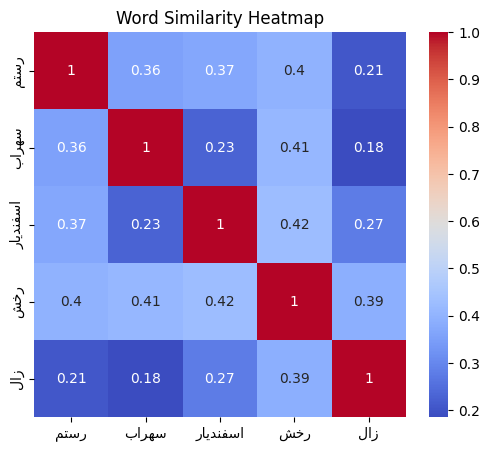

In [172]:
words = list(embeddings.keys())
similarity_matrix = np.zeros((len(words), len(words)))

for i, w1 in enumerate(words):
    for j, w2 in enumerate(words):
        similarity_matrix[i][j] = cosine_sim(embeddings[w1], embeddings[w2])

reshaped_words = [get_display(arabic_reshaper.reshape(word)) for word in words]

plt.figure(figsize=(6, 5))
sns.heatmap(similarity_matrix, annot=True, xticklabels=reshaped_words, yticklabels=reshaped_words, cmap="coolwarm")
plt.title("Word Similarity Heatmap")
plt.show()

# Part 4

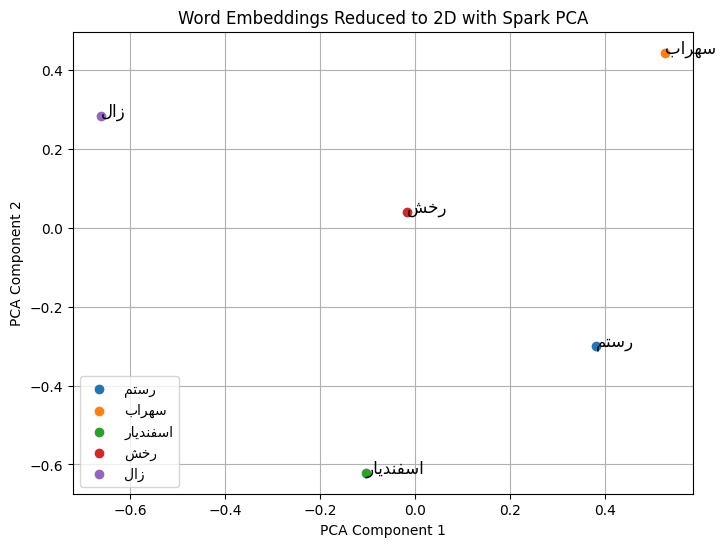

In [173]:
embedding_rows = [Row(word=word, features=Vectors.dense(embeddings[word])) for word in target_words]
embedding_df = spark.createDataFrame(embedding_rows)

pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(embedding_df)
pca_result = pca_model.transform(embedding_df)

pca_coordinates = pca_result.select("word", "pca_features").collect()

plt.figure(figsize=(8, 6))
for row in pca_coordinates:
    word = get_display(arabic_reshaper.reshape(row["word"])) 
    x, y = row["pca_features"].toArray() 
    plt.scatter(x, y, label=word)
    plt.text(x, y, word, fontsize=12)

plt.title("Word Embeddings Reduced to 2D with Spark PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()